# Health Study – Part 1  

This notebook analyzes data from a health study containing information about participants’ age, sex, height, weight, blood pressure, cholesterol level, smoking habits, and disease occurrence.  
The purpose is to perform basic descriptive analysis, simulation, confidence interval estimation, and hypothesis testing in accordance with the assignment instructions.

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

REQUIRED = ["age", "weight", "height", "systolic_bp", "cholesterol"]

df = pd.read_csv("data/health_study_dataset.csv")

missing = [c for c in REQUIRED if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")
else:
    print("All required columns are present.")

df.head()

All required columns are present.


,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0
1,2,47,M,180.4,95.9,144.8,5.18,Yes,0
2,3,59,F,169.9,82.2,151.7,6.16,No,0
3,4,72,M,157.7,93.1,151.0,6.63,No,0
4,5,46,M,192.6,104.1,144.1,5.21,No,0


In [76]:
print("DataFrame info:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

df["sex"] = (
    df["sex"]
    .astype(str).str.strip().str.upper()
    .replace({"FEMALE": "F", "MALE": "M"})
    .astype("category")
)

df["smoker"] = (
    df["smoker"]
    .astype(str).str.strip().str.title()
    .replace({"Y": "Yes", "N": "No"})
    .astype("category")
)

df["sex"] = df["sex"].cat.set_categories(["F", "M"])
df["smoker"] = df["smoker"].cat.set_categories(["No", "Yes"])

df["disease"] = df["disease"].astype(int)

cat_summary = pd.DataFrame({
    "sex": df["sex"].value_counts(),
    "smoker": df["smoker"].value_counts(),
    "disease": df["disease"].value_counts()
})
cat_summary

df.head()

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 56.4+ KB
None

Missing values per column:
id             0
age            0
sex            0
height         0
weight         0
systolic_bp    0
cholesterol    0
smoker         0
disease        0
dtype: int64


,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0
1,2,47,M,180.4,95.9,144.8,5.18,Yes,0
2,3,59,F,169.9,82.2,151.7,6.16,No,0
3,4,72,M,157.7,93.1,151.0,6.63,No,0
4,5,46,M,192.6,104.1,144.1,5.21,No,0


### Missing values check

Missingness was inspected using `df.info()` and `df.isna().sum()`.  
No missing values were found in the required columns, therefore, no imputation or row dropping was performed.  
If any missing values appear later, they will be handled only for the variables used in that specific analysis (for example `df["systolic_bp"].dropna()`), and the target column (`disease`) will not be changed or filled in.

In [77]:
numeric_cols = ["age", "weight", "height", "systolic_bp", "cholesterol"]

desc_stats = df[numeric_cols].agg(["mean", "median", "std", "min", "max"]).T.round(2).sort_values("mean", ascending=False)

print("Descriptive statistics for numerical variables:")
desc_stats

Descriptive statistics for numerical variables:


,mean,median,std,min,max
height,171.85,171.35,9.80,144.4,200.40
systolic_bp,149.18,149.40,12.79,106.8,185.90
weight,73.41,73.20,13.69,33.7,114.40
age,49.43,50.00,14.50,18.0,90.00
cholesterol,4.93,4.97,0.85,2.5,7.88


### Descriptive statistics

The table above shows the main descriptive statistics for the numerical variables.  
The mean, median and standard deviation describe central tendency and variation, giving a clear overview of the participants’ health characteristics.

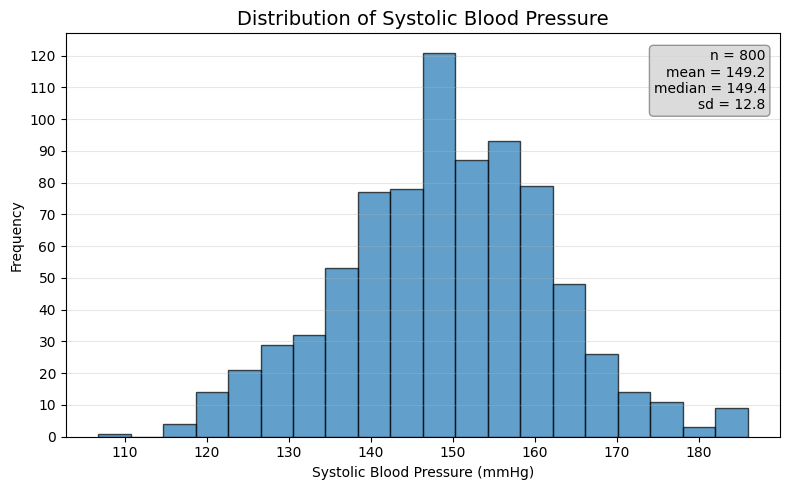

In [78]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df["systolic_bp"], bins=20, edgecolor="black", alpha=0.7)
ax.set_title("Distribution of Systolic Blood Pressure", fontsize=14)
ax.set_xlabel("Systolic Blood Pressure (mmHg)")
ax.set_ylabel("Frequency")
ax.set_yticks(range(0, int(ax.get_ylim()[1]) + 1, 10))
ax.grid(axis="y", alpha=0.3)

ax.text(
    0.98, 0.96,
    f"n = {len(df)}\nmean = {df['systolic_bp'].mean():.1f}\nmedian = {df['systolic_bp'].median():.1f}\nsd = {df['systolic_bp'].std():.1f}",
    transform=ax.transAxes,
    ha="right", va="top",
    bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.8, edgecolor="gray")
)

plt.tight_layout()
plt.show()

### Figure interpretation – Systolic blood pressure

The histogram shows the distribution of systolic blood pressure among all participants.  
The values are centered around 149 mmHg with a roughly symmetric shape, as the mean and median are almost identical.  
This indicates that systolic blood pressure in the sample follows an approximately normal distribution with moderate variability (SD ≈ 13 mmHg).  
The result provides a clear descriptive overview of the population before conducting hypothesis testing in later steps.


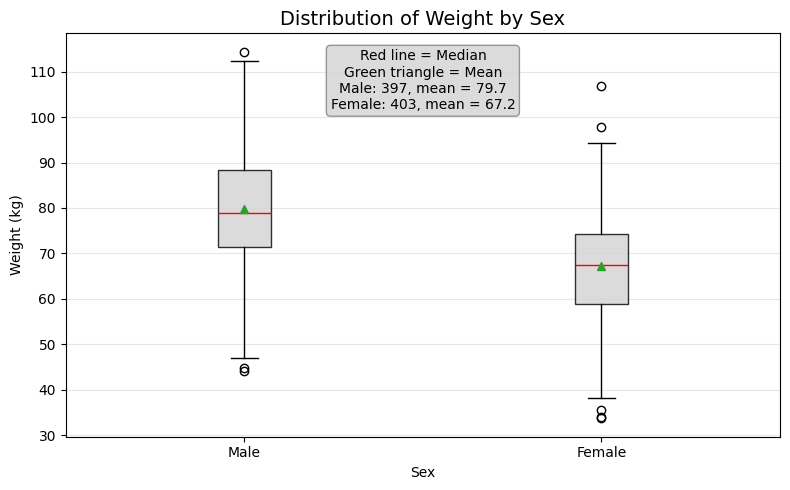

In [79]:
fig, ax = plt.subplots(figsize=(8, 5))

weights_m = df.loc[df["sex"] == "M", "weight"]
weights_f = df.loc[df["sex"] == "F", "weight"]

bp = ax.boxplot(
    [weights_m, weights_f],
    patch_artist=True,
    showmeans=True,
    boxprops=dict(facecolor="lightgray", alpha=0.8, edgecolor="black"),
    medianprops=dict(color="red", linewidth=1)
)

ax.set_xticks([1, 2])
ax.set_xticklabels(["Male", "Female"])
ax.set_title("Distribution of Weight by Sex", fontsize=14)
ax.set_xlabel("Sex")
ax.set_ylabel("Weight (kg)")

ax.grid(axis="y", alpha=0.3)

n_m, n_f = weights_m.count(), weights_f.count()
mean_m, mean_f = weights_m.mean(), weights_f.mean()
median_m, median_f = weights_m.median(), weights_f.median()

ax.text(
    0.5, 0.96,
    "Red line = Median\nGreen triangle = Mean\n"
    f"Male: {n_m}, mean = {mean_m:.1f}\n"
    f"Female: {n_f}, mean = {mean_f:.1f}",
    transform=ax.transAxes,
    ha="center",
    va="top",
    bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.8, edgecolor="gray")
)

plt.tight_layout()
plt.show()

### Figure interpretation – Weight by sex

The boxplot shows the distribution of weight for males and females.  
The red line represents the median, while the green triangle marks the mean for each group.  
A few outliers are visible above and below the whiskers, which is expected in health data and simply indicates individuals with unusually high or low weight values.  

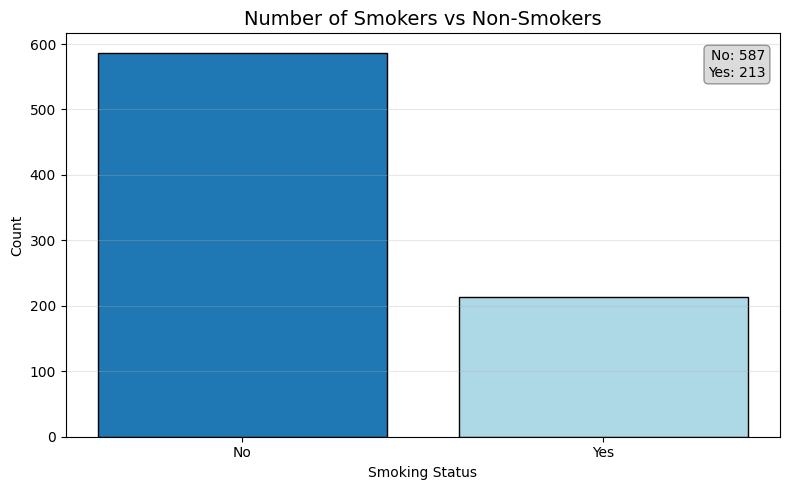

In [80]:
fig, ax = plt.subplots(figsize=(8, 5))

smoker_counts = df["smoker"].value_counts()

ax.bar(smoker_counts.index, smoker_counts.values,
       color=["tab:blue", "lightblue"],
       edgecolor="black")

ax.set_title("Number of Smokers vs Non-Smokers", fontsize=14)
ax.set_xlabel("Smoking Status")
ax.set_ylabel("Count")
ax.grid(axis="y", alpha=0.3)

ax.text(
    0.98, 0.96,
    f"No: {smoker_counts['No']}\nYes: {smoker_counts['Yes']}",
    transform=ax.transAxes,
    ha="right", va="top",
    bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.8, edgecolor="gray")
)

plt.tight_layout()
plt.show()



### Figure interpretation – Smoking status

The bar chart shows the number of smokers and non-smokers in the dataset.
Non-smokers are clearly the largest group, while smokers make up a smaller proportion of the participants.
This gives a simple overview of the distribution of smoking habits before later analysis of how smoking relates to blood pressure and disease.

In [81]:
disease_counts = df["disease"].value_counts().sort_index()
n = len(df)
disease_rate = df["disease"].mean()

print("Observed disease occurrence:")
print(f"\nNumber without disease: {disease_counts[0]}")
print(f"Number with disease: {disease_counts[1]}")
print(f"Observed disease proportion: {disease_rate * 100:.3f}%")

n_sim = 1000
simulated_disease = np.random.binomial(1, disease_rate, size=n_sim)
sim_rate = simulated_disease.mean()

print("\nSimulated disease occurrence (1000 simulated individuals):")
print(f"\nSimulated number with disease: {simulated_disease.sum()}")
print(f"Simulated disease proportion: {sim_rate * 100:.3f}%")


Observed disease occurrence:

Number without disease: 753
Number with disease: 47
Observed disease proportion: 5.875%

Simulated disease occurrence (1000 simulated individuals):

Simulated number with disease: 56
Simulated disease proportion: 5.600%


### Simulation results

The observed proportion of disease in the dataset was compared with a simulated sample of 1000 individuals using the same probability.
The simulated proportion is close to the observed value, with small differences expected due to random variation in the simulation.

In [82]:
bp = df["systolic_bp"]

mean_bp = bp.mean()
std_bp = bp.std()
n = len(bp)

se = std_bp / np.sqrt(n)

z = 1.96
ci_low = mean_bp - z * se
ci_high = mean_bp + z * se

print("95% Confidence Interval for mean systolic blood pressure:")
print(f"\nMean: {mean_bp:.2f} mmHg")
print(f"CI: [{ci_low:.2f}, {ci_high:.2f}] mmHg")


95% Confidence Interval for mean systolic blood pressure:

Mean: 149.18 mmHg
CI: [148.29, 150.07] mmHg


### Confidence interval interpretation

A 95% confidence interval was calculated for the mean systolic blood pressure.
The interval gives a range of reasonable values for the true population mean, and the result shows that the estimate is fairly precise due to the large sample size.

In [83]:
bp_smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"]
bp_non_smokers = df.loc[df["smoker"] == "No", "systolic_bp"]

t_stat, p_value = stats.ttest_ind(bp_smokers, bp_non_smokers, equal_var=False)

print("T-test comparing mean systolic blood pressure:")
print(f"\nMean (smokers): {bp_smokers.mean():.2f} mmHg")
print(f"Mean (non-smokers): {bp_non_smokers.mean():.2f} mmHg")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")

p_value_one_sided = p_value / 2
print(f"One-sided p-value (smokers > non-smokers): {p_value_one_sided:.4f}")

T-test comparing mean systolic blood pressure:

Mean (smokers): 149.52 mmHg
Mean (non-smokers): 149.05 mmHg
t-statistic: 0.450
p-value: 0.6527
One-sided p-value (smokers > non-smokers): 0.3264


### Hypothesis test interpretation

A t-test was used to compare the mean systolic blood pressure between smokers and non-smokers.
The difference in mean blood pressure between the groups is very small (about 0.5 mmHg), and the p-value is high.
This indicates that there is no statistical evidence that smokers have higher systolic blood pressure than non-smokers.

In [84]:
bp = df["systolic_bp"]

n_boot = 5000
boot_means = []

for _ in range(n_boot):
    sample = bp.sample(frac=1, replace=True)
    boot_means.append(sample.mean())

boot_means = np.array(boot_means)

ci_low = np.percentile(boot_means, 2.5)
ci_high = np.percentile(boot_means, 97.5)

print("Bootstrap 95% Confidence Interval for mean systolic blood pressure:")
print(f"\nCI: [{ci_low:.2f}, {ci_high:.2f}] mmHg")


Bootstrap 95% Confidence Interval for mean systolic blood pressure:

CI: [148.34, 150.08] mmHg


### Bootstrap confidence interval interpretation

A bootstrap procedure was used to estimate a 95% confidence interval for the mean systolic blood pressure.
The interval is based on resampling the data many times and reflects how the sample mean varies due to random variation.
The resulting interval is similar in width to the normal-approximation interval, indicating that the estimate of the mean is stable.

In [85]:
n_smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"].shape[0]
n_non_smokers = df.loc[df["smoker"] == "No", "systolic_bp"].shape[0]

bp_all = df["systolic_bp"]
std_bp = bp_all.std()

mu_non = bp_all.mean()
mu_smokers_true = mu_non + 5
mu_non_true = mu_non

alpha = 0.05
n_sim = 5000

rejections = 0

for _ in range(n_sim):
    sim_non = np.random.normal(loc=mu_non_true, scale=std_bp, size=n_non_smokers)
    sim_smokers = np.random.normal(loc=mu_smokers_true, scale=std_bp, size=n_smokers)
    
    t_stat, p_value_two_sided = stats.ttest_ind(sim_smokers, sim_non, equal_var=False)
    
    p_value_one_sided = p_value_two_sided / 2
    
    if p_value_one_sided < alpha and sim_smokers.mean() > sim_non.mean():
        rejections += 1

power_estimate = rejections / n_sim

print("Power simulation for t-test (smokers > non-smokers):")
print(f"\nAssumed true difference in means: 5 mmHg")
print(f"Estimated power (alpha = 0.05): {power_estimate * 100:.2f}%")


Power simulation for t-test (smokers > non-smokers):

Assumed true difference in means: 5 mmHg
Estimated power (alpha = 0.05): 99.98%


### Power simulation – 5 mmHg difference

A power simulation was first performed assuming a true mean difference of 5 mmHg in systolic blood pressure between smokers and non-smokers.
The estimated power was essentially 100 %, meaning that the t-test would almost always detect such a large difference with the current sample size.
This shows that the test is very sensitive to large effects, while much smaller differences are harder to detect.

In [86]:
n_smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"].shape[0]
n_non_smokers = df.loc[df["smoker"] == "No", "systolic_bp"].shape[0]

bp_all = df["systolic_bp"]
std_bp = bp_all.std()

mu_non = bp_all.mean()
mu_smokers_true = mu_non + 0.47
mu_non_true = mu_non

alpha = 0.05
n_sim = 5000

rejections = 0

for _ in range(n_sim):
    sim_non = np.random.normal(loc=mu_non_true, scale=std_bp, size=n_non_smokers)
    sim_smokers = np.random.normal(loc=mu_smokers_true, scale=std_bp, size=n_smokers)
    
    t_stat, p_value_two_sided = stats.ttest_ind(sim_smokers, sim_non, equal_var=False)
    
    p_value_one_sided = p_value_two_sided / 2
    
    if p_value_one_sided < alpha and sim_smokers.mean() > sim_non.mean():
        rejections += 1

power_estimate = rejections / n_sim

print("Power simulation for t-test (smokers > non-smokers):")
print(f"\nAssumed true difference in means: 0.47 mmHg")
print(f"Estimated power (alpha = 0.05): {power_estimate * 100:.2f}%")

Power simulation for t-test (smokers > non-smokers):

Assumed true difference in means: 0.47 mmHg
Estimated power (alpha = 0.05): 11.92%


### Power simulation – observed difference

A second power simulation was performed using the observed mean difference of about 0.47 mmHg between smokers and non-smokers.
The estimated power is only around 0.11, meaning that the t-test would detect such a small effect in roughly 11% of repeated studies.
This low power helps explain why the original hypothesis test did not find a statistically significant difference between the groups.

### Method choices and motivation  

Several statistical methods were used in this analysis, each chosen for a specific purpose and based on standard approaches in introductory data analysis.

**Descriptive statistics and visualisations**  
Measures such as mean, median and standard deviation were calculated to summarise the main health variables. Histogram, boxplot and bar chart visualisations were used to explore distributions and group differences. This follows common practice in exploratory data analysis and helps check assumptions before applying formal statistical tests.

**Simulation of disease occurrence**  
The observed disease proportion in the dataset was used to simulate new samples with NumPy’s `np.random.binomial`. This illustrates how random variation affects sample proportions and connects the empirical data to the binomial model (NumPy documentation: `numpy.random.binomial`).

**Confidence intervals (normal approximation and bootstrap)**  
A 95% confidence interval for mean systolic blood pressure was first computed using the normal approximation: the sample mean plus or minus 1.96 times the standard error. This method is appropriate here because the sample is large and the distribution of systolic blood pressure is approximately symmetric (central limit theorem; standard statistics references).  
To check robustness, a bootstrap confidence interval was also computed by repeatedly resampling the data. The bootstrap does not assume normality and is widely recommended for estimating uncertainty in sample estimates (Efron & Tibshirani, 1993).

**Hypothesis test (t-test)**  
Differences in mean systolic blood pressure between smokers and non-smokers were tested using an independent two-sample t-test (Welch’s version) via `scipy.stats.ttest_ind`. This test is suitable for comparing means between two independent groups and is commonly used in similar health data analyses (SciPy documentation: `scipy.stats.ttest_ind`).

**Power simulation**  
Power was estimated using a Monte Carlo simulation approach. Synthetic datasets were generated with NumPy’s `np.random.normal`, using the observed sample size and standard deviation. For each dataset, a t-test was applied, and the proportion of significant results was taken as the estimated power. This method is a practical way to assess how often a statistical test would detect an effect
